# Understanding the dataset
Undestanding this dataset has been quite complex due to the lack of a comprehensive documentation. However, we feel like it's important to understand which data is given to the model: a complete black-box approach is at least dangerous.
## The folders
We have not fully understood the difference between test and training data yet. However, we now know that the data is structured in **tiles**.
Each tile is a folder and corresponds to a geographical area of around 110km × 110km. The tile name (which is really the folder name), look something like `29SND`. One can use `en.get_coords_from_tile("29SND")` to get the coordinates of the bounds for such tile. 
Each folder contains many files with a name like `29SND_2017-06-20_2017-11-16_2105_2233_1721_1849_32_112_26_106`. Each of such files contains information about a location inside the tile.
## The cubes
To be precise, each file like `29SND_2017-06-20_2017-11-16_2105_2233_1721_1849_32_112_26_106` contains photos (and other infos) of a location inside tile `29SND` at different time-steps from `2017-06-20` to `2017-11-16` (readable in the file name). Finally, the rest of the name encodes the location addressed by the file. One can use `en.get_coords_from_cube(filename, return_meso=True)` to view the coordinates of the boundary of such location. **NOTE: this function is broken, and sometimes it outputs the wrong location**. 
Finally, what is inside a file? Four cubes:
* highresdynamic (5 dimensional)
    * x-axis (128)
    * y-axis (128)
    * channel (5 or 7)
        * B, G, R, near-infrared, Sen2Cor Cloud Mask, ESA Scene Classification, EarthNet2021 Data Quality Mask
    * time (20, 40 or 70)
* mesodynamic
    * x-axis (80)
    * y-axis (80)
    * channel (5)
        * Precipitation (RR), Sea pressure (PP), Mean temperature (TG), Minimum temperature (TN), Maximum temperature (TX)
    * time (20, 40 or 70)
* highresstatic (the value represents the altitude)
    * x-axis (128)
    * y-axis (128)
* mesostatic (the value represents the altitude)
    * x-axis (80)
    * y-axis (80)
    
The main thing to highlight here is the relation between the highres cubes and the meso cubes. The highres cubes map an area (bounded by `en.get_coords_from_cube(filename, return_meso=True)` if it was correct) of 2.56km × 2.56km, with a resolution of 20m (128*20m = 2560m). The meso cubes, on the other hand, map a much larger area: around 100km × 100km. With a resolution of 80px this yealds that each pixel cover an area of around 1.25km × 1.25km. Hence, the highres location only occupies the central 4 pixel of the meso image.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthnet as en
from os import walk
import os
from my_coord import get_coords_from_cube as my_coord


import os
import json
from pyproj import Transformer
from earthnet.coords_dict import COORDS
import pickle

In [21]:
#plt.imshow(hrd[:,:,0,0])
context = "../Data/extreme/extreme_test_split/context/32UQC"
filenames = next(walk(context), (None, None, []))[2] 

In [20]:
with open( "extreme_test_split_context_data_paths.pkl",'rb') as f:
    filenames = pickle.load(f)

In [45]:
def mc(cubename: str, return_meso: bool = False):
    cubetile,_, _,  hr_y_min, hr_y_max,hr_x_min, hr_x_max, meso_x_min, meso_x_max, meso_y_min, meso_y_max = os.path.splitext(cubename)[0].split("_")

    tile = NEWCOORD[cubetile]

    transformer = Transformer.from_crs(tile["EPSG"], 4326, always_xy = True)

    tile_x_min, tile_y_max = transformer.transform(tile["MinLon"],tile["MaxLat"], direction = "INVERSE")

    a = 20
    tile_x_min = tile_x_min

    cube_x_min = tile_x_min + a * float(hr_x_min)
    cube_x_max = tile_x_min + a * float(hr_x_max)
    cube_y_min = tile_y_max - a * float(hr_y_min)
    cube_y_max = tile_y_max - a * float(hr_y_max)
    
    cube_lon_min, cube_lat_min = transformer.transform(cube_x_min, cube_y_max)
    cube_lon_max, cube_lat_max = transformer.transform(cube_x_max, cube_y_min)

    #print("{0}, {1}".format(cube_lat_min,cube_lon_min))
    cube_lat_min
    
    return cube_lon_min, cube_lat_min, cube_lon_max, cube_lat_max

In [46]:
cubetiles = ["32UPC","32UMC","32UNC","32UQC"]
north_west_cube = ["","","",""]
west = 4*[100000]
north = 4*[0]
for fn in filenames:
    cubetile,_, _,  hr_y_min, hr_y_max, hr_x_min, hr_x_max, meso_x_min, meso_x_max, meso_y_min, meso_y_max = os.path.splitext(fn[158:])[0].split("_")
    idx = cubetiles.index(cubetile)
    hr_x_min = float(hr_x_min)
    if hr_x_min <= west[idx] :
        north_west_cube[idx] = fn[158:]
        west[idx] = hr_x_min
print(north_west_cube)
print(west)
print(north)
    
    


ValueError: not enough values to unpack (expected 11, got 1)

In [ ]:
print(COORDS["32UPC"])
print(COORDS["32UMC"])
print(COORDS["32UNC"])
print(COORDS["32UQC"])

{'EPSG': 32632, 'MinLon': 10.4361, 'MaxLon': 12.0778, 'MinLat': 51.3245, 'MaxLat': 52.3414}
{'EPSG': 32632, 'MinLon': 7.5315, 'MaxLon': 9.1433, 'MinLat': 51.3544, 'MaxLat': 52.3504}
{'EPSG': 32632, 'MinLon': 8.9997, 'MaxLon': 10.6114, 'MinLat': 51.3526, 'MaxLat': 52.3505}
{'EPSG': 32632, 'MinLon': 11.8702, 'MaxLon': 13.54, 'MinLat': 51.2789, 'MaxLat': 52.314}


32UMC_2018-01-31_2018-11-26_1081_1209_1209_1337_16_96_18_98.npz


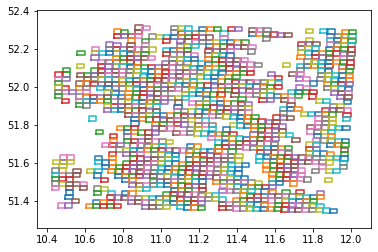

In [ ]:
shift = 158
print(filenames[0][shift:])

legend = []
for i, file in enumerate(filenames):
    if file[shift:shift+5] == "32UPC":
        #cord = my_coord(file[158:], return_meso=True)
        cord_n = mc(file[shift:], return_meso=True)
        #plt.plot([cord[0],cord[0],cord[2],cord[2],cord[0]], [cord[1],cord[3],cord[3],cord[1], cord[1]])
        plt.plot([ cord_n[0],cord_n[0] , cord_n[2] , cord_n[2] , cord_n[0]], [cord_n[1],cord_n[3],cord_n[3],cord_n[1], cord_n[1]], '-')
        #print("{0} -> ({1})".format(i,file[8:]))
        cord = cord_n
        #print("    east: {0} - {1}".format(cord[0], cord[2]))
        #print("    nord: {0} - {1}".format(cord[1], cord[3]))
        legend.append(str(i))
        #legend.append("{0} - new".format(i))
        #plt.plot([cord[4],cord[4],cord[6],cord[6],cord[4]], [cord[5],cord[7],cord[7],cord[5], cord[5]])
plt.axis('equal')
#plt.legend(legend)
plt.show()

Here we look at some files inside the tile `29SND`

In [ ]:
filenames[0][shift:shift+5]

'32UMC'

In [63]:
NEWCOORD = {
    "32UPC" : {
        "MinLon" : 10.4361,
        "MaxLat" : 52.3414,
        'EPSG': 32632
    },
    "32UMC" : {
        "MinLon" : 7.5315,
        "MaxLat" : 52.3504,
        'EPSG': 32632
    },
    "32UNC" : {
        "MinLon" : 8.9997,
        "MaxLat" : 52.314,
        'EPSG': 32632
    },
    "32UQC" : {
        "MinLon" : 11.9352,
        "MaxLat" : 52.315,
        'EPSG': 32632
    }
}

32UQC_2018-01-28_2018-11-23_5305_5433_3257_3385_82_162_50_130.npz
51.33440279311966, 12.805705108303904


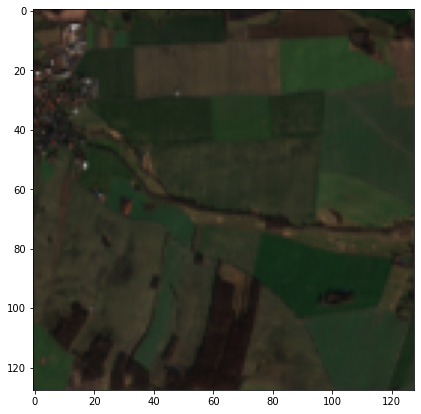

In [62]:
ind = 2
print(filenames[ind][8:])
coord = mc(filenames[ind][8:])
print("{0}, {1}".format(coord[3],coord[0]))

sample = np.load(os.path.join(context , filenames[ind]))
hrd = sample['highresdynamic']
md = sample["mesodynamic"]

# Accessing high-resolution and mesoscale static variables (the EUDEM digital elevation model)
hrs = sample["highresstatic"]
ms = sample["mesostatic"]
time = 3
pic = np.flip(hrd[:,:,:3,time].astype(float),2)*3 
plt.rcParams['figure.figsize'] = [15, 7]
im = plt.imshow(pic)
plt.savefig("im"+str(time),bbox_inches="tight", pad_inches = 0)

#51.308834, 13.230445

In [ ]:
# single file
ind = 0
print(filenames[ind])
sample = np.load(os.path.join(context , filenames[ind]))
hrd = sample['highresdynamic']
md = sample["mesodynamic"]

# Accessing high-resolution and mesoscale static variables (the EUDEM digital elevation model)
hrs = sample["highresstatic"]
ms = sample["mesostatic"]

context_29SND_2017-06-20_2017-11-16_953_1081_3641_3769_14_94_56_136.npz


Here we draw the satellite picture at the time `time` on the left. On the right we draw the elevation map. All of this is in the highres cubes. Furthermore, we print the coordinates of the supposed boundary of the highres area interested. However, checking on google earth, it seems that those locations are wrong.

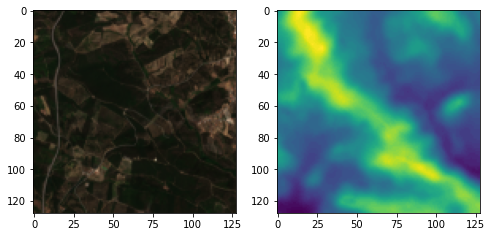

In [ ]:
time = 3

pic = np.flip(hrd[:,:,:3,time].astype(float),2)*2 #Times 2 makes it lighter
fig, axs = plt.subplots(nrows=1,ncols = 2)
fig.set_size_inches(8,4)
axs[0].imshow(pic)
axs[1].imshow(hrs.astype(float))
#cord = en.get_coords_from_cube(filenames[ind], return_meso=True)
#print(str(cord[1]) +','+ str(cord[0]))
#print(str(cord[3]) +','+ str(cord[2]))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


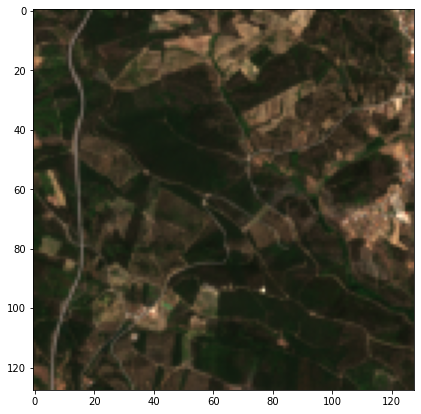

In [ ]:
time = 3
pic = np.flip(hrd[:,:,:3,time].astype(float),2)*3 
plt.rcParams['figure.figsize'] = [15, 7]
im = plt.imshow(pic)
plt.savefig("im"+str(time),bbox_inches="tight", pad_inches = 0)

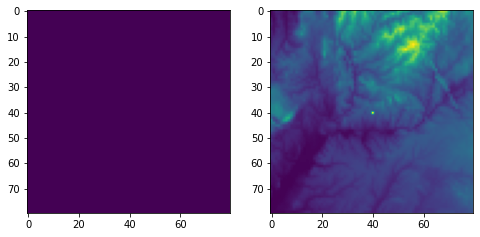

In [ ]:
pic = md[:,:,0,19].astype(float) #Times 2 makes it lighter
pic2 = ms.astype(float)
pic2[40:41,40:41] = np.max(pic2)
#pic2[41,41] = np.max(pic2)
fig, axs = plt.subplots(nrows=1,ncols = 2)
fig.set_size_inches(8,4)
axs[0].imshow(pic)
axs[1].imshow(pic2)
#cord = en.get_coords_from_cube(filenames[ind], return_meso=True)
plt.show()

In [ ]:
ndvi = ((hrd[:, :, 3, :] - hrd[ :, :, 2, :]) / (
                hrd[ :, :, 3, :] + hrd[ :, :, 2, :] + 1e-6))
cloud_mask = 1 - np.nan_to_num(hrd[:, :, 6, :], nan = 0)
vag_mask = 1 - (1 - (hrd[:, :, 5, :] == 4)) * (1 - (hrd[:, :, 5, :] == 5))
ndvi = np.nan_to_num(ndvi, nan=0)
vag_mask = 1 - ((1 - np.nan_to_num(vag_mask, nan=0))*(1-cloud_mask)) 
#vag_mask = np.repeat(vag_mask.prod(axis=2)[...,np.newaxis], 30, axis=-1)
ndvi=ndvi*cloud_mask*vag_mask
ims = plt.imshow(ndvi[...,time])
plt.colorbar(ims)
plt.plot()

IndexError: index 6 is out of bounds for axis 2 with size 5

In [ ]:
np.linspace(0.1,1,10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
# Take out cloudy days
splits = np.linspace(0.1,1,10)
q = np.quantile(ndvi, splits, axis = (0,1))

valid_ndvi_time = q[0]!=0
q[0,valid_ndvi_time]

x = np.arange(30)[valid_ndvi_time]
for i in range(len(splits)):
    plt.plot(x, q[i,valid_ndvi_time], '-*')

plt.plot(np.arange(150)/5 -1, md[40,40,0,:])
#plt.plot(np.arange(150)/5 -1, md[40,40,2,:])
plt.plot(np.arange(150)/5 -1, md[40,40,3,:])
#plt.plot(np.arange(150)/5 -1, md[40,40,4,:])




IndexError: boolean index did not match indexed array along dimension 0; dimension is 30 but corresponding boolean dimension is 20

(5, 30)


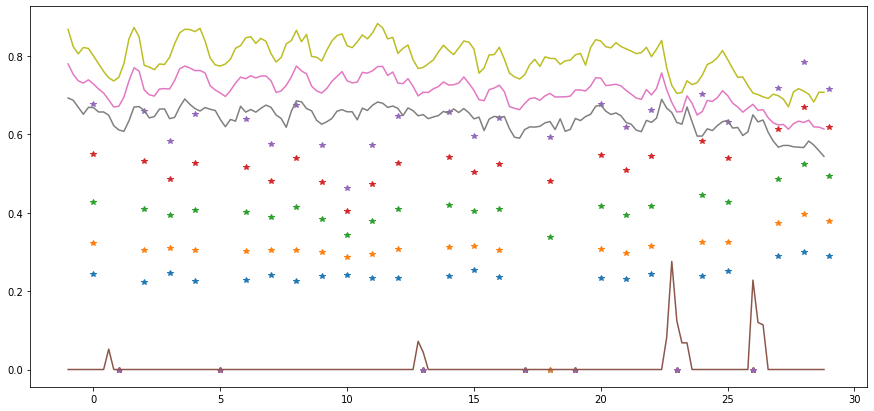

In [ ]:
q = np.quantile(ndvi, [0.1,0.25,0.5,0.75,0.9], axis = (0,1))
print(q.shape)
plt.plot(q[0],'*')
plt.plot(q[1],'*')
plt.plot(q[2],'*')
plt.plot(q[3],'*')
plt.plot(q[4],'*')
plt.plot(np.arange(150)/5 -1, md[40,40,0,:])
plt.plot(np.arange(150)/5 -1, md[40,40,2,:])
plt.plot(np.arange(150)/5 -1, md[40,40,3,:])
plt.plot(np.arange(150)/5 -1, md[40,40,4,:])

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

In [ ]:
np.repeat(vag_mask.prod(axis=2)[...,np.newaxis], 30, axis=-1).shape

(128, 128, 30)